<a href="https://colab.research.google.com/github/abhilashhn1993/What-does-my-cousin-tweet-/blob/master/TweetAnalysisandTopicModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install GetoldTweets3
!pip install spacy
!pip install pyLDAvis

In [0]:
import GetOldTweets3 as got
import re
import string
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import os

from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
import nltk; 
nltk.download('stopwords')

In [0]:
from google.colab import files
uploaded = files.upload()

In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Arvind_Tweets.csv']))

In [0]:
df.head()

In [0]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [0]:
#Adding Extra Stopwords to be removed from the dataset
stop_words.extend(['http', 'https', 'twitter', 'www', 'instagram', 'com'])
stop_words.extend(['make','say','go','bit','know','look','need','want','much','with','even','give','day','come','many','thing','well'])

In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt 

def remove_stopwords(text):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in text]

def convert_to_string(df):
  for row in range(len(df)):
    df.iloc[row].Tweets = ' '.join([str(element) for element in df.iloc[row].Tweets])
  return df

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Emails
df['Tweets'] = [re.sub('\S*@\S*\s?', '', sent) for sent in df['Tweets']]
# Remove new line characters
df['Tweets'] = [re.sub('\s+', ' ', sent) for sent in df['Tweets']]
# Remove distracting single quotes
df['Tweets'] = [re.sub("\'", "", sent) for sent in df['Tweets']]
#Remove consecutive characters
df['Tweets'] = np.vectorize(remove_pattern)(df['Tweets'], "@[\w]*")

In [19]:
df['Tweets'] = list(sent_to_words(df['Tweets']))
df['Tweets'] = remove_stopwords(df['Tweets'])
df.head()

,Tweets,Length of Tweets,DateTime,Day,Date,Year,Time,IST time,Hashtags
0,"[adding, origin, word, quarantine, came, itali...",118,Tue Apr 07 09:31:16 +0000 2020,Tue,Apr 07 2020,2020,0.396713,0.625694,NaN
1,"[please, check, helps]",82,Fri Apr 03 17:48:14 +0000 2020,Fri,Apr 03 2020,2020,0.741829,0.970833,NaN
2,"[scale, testing, using, method, please, consider]",133,Fri Apr 03 17:42:55 +0000 2020,Fri,Apr 03 2020,2020,0.738137,0.966667,NaN
3,"[use, data, theverge, google, location, data, ...",154,Fri Apr 03 07:22:24 +0000 2020,Fri,Apr 03 2020,2020,0.307222,0.536111,NaN
4,"[arena, testing, enough, agreed, concern, whos...",107,Sun Mar 29 11:51:05 +0000 2020,Sun,Mar 29 2020,2020,0.493808,0.722917,NaN


In [0]:
nlp = spacy.load('en', disable=['parser', 'ner'])
df['Tweets'] = lemmatization(df['Tweets'], allowed_postags=['NOUN','ADJ','VERB','ADV'])

In [0]:
df['Tweets'] = remove_stopwords(df['Tweets'])

In [0]:
df = convert_to_string(df)

In [0]:
df['Tweets'] = df['Tweets'].str.join(" ")
df.head()

In [0]:
words = ' '.join([text for text in df['Tweets']])

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

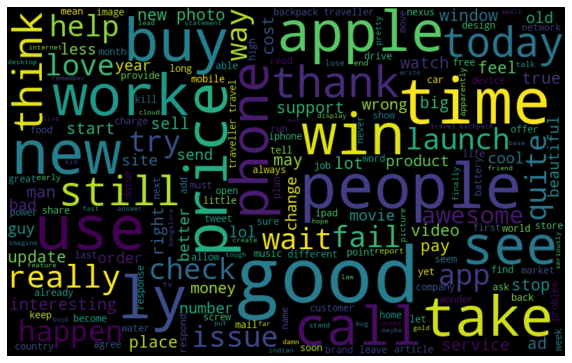

In [32]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
# function to collect hashtags
def hashtag_extract(df):
    hashtags = df.loc[df['Hashtags'].notnull() , ['Hashtags']]
    hashtags = hashtags['Hashtags'].tolist()
    hashtags = extract_hashtags_seperate(hashtags)
    return hashtags

In [0]:
def extract_hashtags_seperate(x):
  aList = []
  for i in x:
    ht = re.findall(r"#(\w+)", i)
    aList.append(ht)
  return aList

In [0]:
tweet_hashtags = hashtag_extract(df)

In [0]:
tweet_hashtags = sum(tweet_hashtags, [])

In [0]:
print(tweet_hashtags)

In [0]:
tags = nltk.FreqDist(tweet_hashtags)

In [0]:
htags_data = pd.DataFrame({'Hashtag': list(tags.keys()),
                  'Count': list(tags.values())})

In [0]:
htags_data.sort_values(by=['Count'], ascending=False)

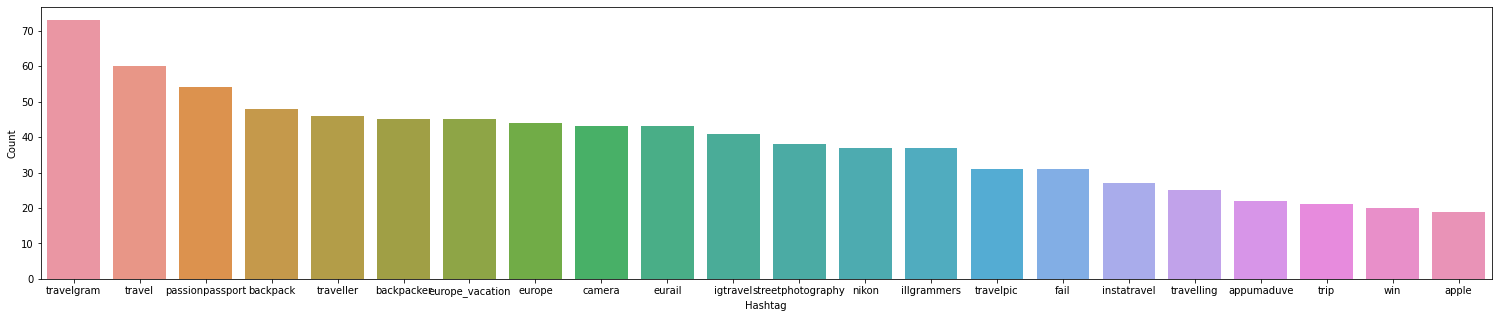

In [45]:
# selecting top 10 most frequent hashtags     
htags = htags_data.nlargest(columns="Count", n = 22) 
plt.figure(figsize=(26,5))
ax = sns.barplot(data=htags, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

**LDA Topic Modeling**

In [0]:
df['Tweets'] = list(sent_to_words(df['Tweets']))
df['Tweets'] = remove_stopwords(df['Tweets'])
df['Tweets'] = lemmatization(df['Tweets'], allowed_postags=['NOUN','ADJ','VERB','ADV'])
df['Tweets'] = remove_stopwords(df['Tweets'])

In [0]:
data_lemmatized = df['Tweets']
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

In [0]:
print(data_lemmatized)

In [0]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [0]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [0]:
from corextopic import corextopic as ct